In [2]:
%matplotlib inline
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas as pd
import json
from scipy.optimize import curve_fit
from scipy import stats
from pprint import pprint
from sklearn.metrics import r2_score
import matplotlib as mpl
import random 
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.unicode'] = True

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
!radical-stack

/opt/anaconda2/lib/python2.7/site-packages/radical/pilot
/opt/anaconda2/lib/python2.7/site-packages/radical/utils
/opt/anaconda2/lib/python2.7/site-packages/radical/entk
/opt/anaconda2/lib/python2.7/site-packages/radical/saga
/opt/anaconda2/lib/python2.7/site-packages/radical/analytics

  python               : 2.7.14
  pythonpath           : 
  virtualenv           : /home/aymen/jupyter

  radical.analytics    : 0.70.0
  radical.entk         : 0.70.0
  radical.pilot        : 0.70.0
  radical.saga         : 0.70.0
  radical.utils        : 0.70.0



In [3]:
images = pd.read_csv('../Data/Geolocation_Image_pairs.csv')
des2_geolocating = pd.DataFrame(columns=['Image1','Image2','TotalSize','Time'])

sids = ['../../../paper_data/Design2a/design2a_11k_test5/'] 

for sid in sids:
    geo_files = glob(sid+'/pilot.0000/unit.00*/geolocate*.csv')
    for geo_file in geo_files:
        Geolocating = pd.read_csv(geo_file)
        for index, row in Geolocating.iterrows():
            
            if row['Image'] == 'configure' or row['Image'] == 'connect' or row['Image'] == 'disconnect' :
                skip = True
                continue
                
            else :
                try:
                    image1 = row['Image'].split('_/')[1]
                    image2 = row['Image'].split('_/')[-1]
                    size1  = images.loc[images['ImageName1'] == '/'+image1].loc[images['ImageName2'] == '/'+image2]['SIZE1'].values[0]
                    size2  = images.loc[images['ImageName1'] == '/'+image1].loc[images['ImageName2'] == '/'+image2]['SIZE2'].values[0]
                    time1   = row['End'] - row['Start']
                    des2_geolocating.loc[len(des2_geolocating)] = [image1,image2,size1+size2,time1]
                
                except Exception as e:

                    print row['Image']
                    print (e) 

                

#for i in range(len(size1)):
                       
des2_geolocating_binned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin',
                                                'SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])

des2_geolocating.sort_values(by=['TotalSize'],inplace=True)
des2_geolocating.reset_index(drop='index',inplace=True)
ss = des2_geolocating.reset_index(drop='index')

for i in range(1024,5120,187): # This is 92% of the images there are ranges that have 0 samples after 10800KBs
    print i
    des2_geolocating_binned.loc[len(des2_geolocating_binned)] = [[i, i + 187],ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values,
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.mean(),
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.std(),
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.min(),
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.max(),
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values,
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.mean(),
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.std(),
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.min(),
                                                                        ss[(i/1024.0 < des2_geolocating['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.max()]

1024
1211
1398
1585
1772
1959
2146
2333
2520
2707
2894
3081
3268
3455
3642
3829
4016
4203
4390
4577
4764
4951


In [4]:
def func_lin(x, a, b):
    return a * x + b

xdata = des2_geolocating_binned['SizeMean'].values
ydata = des2_geolocating_binned['TimeMean'].values
poptTillingDes1lin, pcovTillingDes1lin = curve_fit(func_lin,xdata,ydata)
y = func_lin(xdata, *poptTillingDes1lin)
s_test = np.sqrt(np.sum(np.power((des2_geolocating_binned['TimeMean'].values - y), 2))/(len(y)-2))
print 'Linear: R-squared', r2_score(des2_geolocating_binned['TimeMean'].values,y), '$S_{error}$', s_test
print 'Parameter Values', poptTillingDes1lin

Linear: R-squared 0.7571825164820905 $S_{error}$ 0.36874851706155437
Parameter Values [0.53768924 1.50686487]


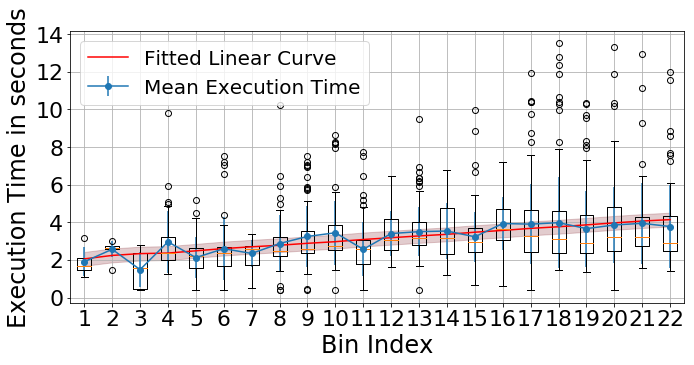

In [5]:
x = des2_geolocating_binned['SizeMean'].values

fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(11,5),sharey='row')
_ = axis.boxplot(des2_geolocating_binned['TimeArray'].values)
_ = axis.errorbar(range(1,23),des2_geolocating_binned['TimeMean'].values,yerr=des2_geolocating_binned['TimeStd'].values,marker='o',label='Mean Execution Time')
_ = axis.plot(range(1,23), y, 'r-', label="Fitted Linear Curve")
_ = axis.fill_between(range(1,23),y - s_test, y + s_test, color=reds(250), alpha=0.2)
_ = axis.set_ylabel('Execution Time in seconds',fontsize=24)
_ = axis.set_xlabel('Bin Index',fontsize=24)
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=22)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=22)
_ = axis.grid('on')
_ = axis.legend(fontsize=20)
fig.savefig('../Data/des2_geo_stage_0_tx_box.pdf',dpi=800,bbox_inches='tight')


In [7]:
images = pd.read_csv('../Data/Geolocation_Image_pairs.csv')
des2_ransacking = pd.DataFrame(columns=['Image1','Image2','TotalSize','Time'])

sids = ['../../../paper_data/Design2a/design2a_11k_test5/'] 

for sid in sids:
    ransac_files = glob(sid+'/pilot.0000/unit.00*/ransac*.csv')
    for ransac_file in ransac_files:
        Ransacking = pd.read_csv(ransac_file)
        for index, row in Ransacking.iterrows():
            
            if row['Image'] == 'configure' or row['Image'] == 'connect' or row['Image'] == 'disconnect' :
                skip = True
                continue
                
            else :
                try:
                    image1 = 'pylon5/mc3bggp/aymen/geolocation_dataset_new/['+row['Image'].split('_[')[1]+'.tif'
                    image2 = 'pylon5/mc3bggp/aymen/geolocation_dataset_new/['+row['Image'].split('_[')[2].replace('csv','tif')
                    size1  = images.loc[images['ImageName1'] == '/'+image1].loc[images['ImageName2'] == '/'+image2]['SIZE1'].values[0]
                    size2  = images.loc[images['ImageName1'] == '/'+image1].loc[images['ImageName2'] == '/'+image2]['SIZE2'].values[0]
                    time1   = row['End'] - row['Start']
                    des2_ransacking.loc[len(des2_ransacking)] = [image1,image2,size1+size2,time1]

                except Exception as e:

                    
                    print (e) 

des2_ransacking_binned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin',
                                                'SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])

des2_ransacking.sort_values(by=['TotalSize'],inplace=True)
des2_ransacking_binned.reset_index(drop='index',inplace=True)
ss = des2_ransacking.reset_index(drop='index')

for i in range(1024,5120,187): # This is 92% of the images there are ranges that have 0 samples after 10800KBs
    print i
    des2_ransacking_binned.loc[len(des2_ransacking_binned)] = [[i, i + 187],ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values,
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.mean(),
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.std(),
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.min(),
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.max(),
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values,
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.mean(),
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.std(),
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.min(),
                                                                        ss[(i/1024.0 < ss['TotalSize']) & (ss['TotalSize'] < ((i + 187)/1024.0))]['Time'].values.max()]

1024
1211
1398
1585
1772
1959
2146
2333
2520
2707
2894
3081
3268
3455
3642
3829
4016
4203
4390
4577
4764
4951


In [8]:
def func_lin(x, a, b):
    return a * x + b

xdata = des2_ransacking_binned['SizeMean'].values
ydata = des2_ransacking_binned['TimeMean'].values
poptTillingDes1lin, pcovTillingDes1lin = curve_fit(func_lin,xdata,ydata)
y = func_lin(xdata, *poptTillingDes1lin)
s_test = np.sqrt(np.sum(np.power((des2_ransacking_binned['TimeMean'].values - y), 2))/(len(y)-2))
print 'Linear: R-squared', r2_score(des2_ransacking_binned['TimeMean'].values,y), '$S_{error}$', s_test
print 'Parameter Values', poptTillingDes1lin

Linear: R-squared 0.8912576969764335 $S_{error}$ 0.011870751414988015
Parameter Values [0.02823201 0.25785143]


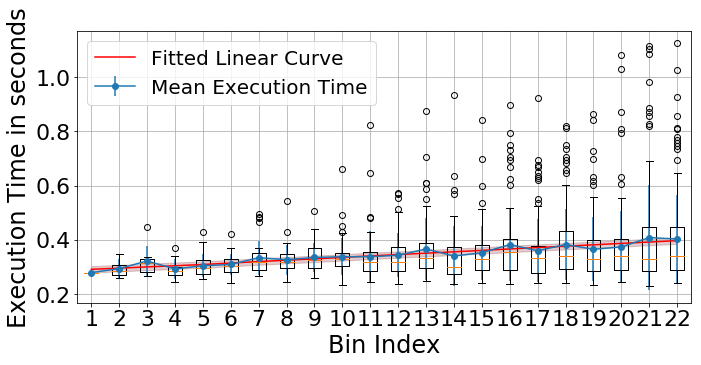

In [9]:
x = des2_ransacking_binned['SizeMean'].values

fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(11,5),sharey='row')
_ = axis.boxplot(des2_ransacking_binned['TimeArray'].values)
_ = axis.errorbar(range(1,23),des2_ransacking_binned['TimeMean'].values, yerr=des2_ransacking_binned['TimeStd'].values,marker='o',label='Mean Execution Time')
_ = axis.plot(range(1,23), y, 'r-', label="Fitted Linear Curve")
_ = axis.fill_between(range(1,23),y - s_test, y + s_test, color=reds(250), alpha=0.2)
_ = axis.set_ylabel('Execution Time in seconds',fontsize=24)
_ = axis.set_xlabel('Bin Index',fontsize=24)
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=22)
_ = axis.set_yticklabels(axis.get_yticks().astype('float').tolist(),fontsize=22)
_ = axis.grid('on')
_ = axis.legend(fontsize=20)
fig.savefig('../Data/des2_geo_stage_1_tx_box.pdf',dpi=800,bbox_inches='tight')


In [9]:
des2_ransacking_binned['TimeMean']

0     0.307392
1     0.357092
2     0.346869
3     0.329893
4     0.335802
5     0.353781
6     0.351472
7     0.343536
8     0.359188
9     0.372684
10    0.393225
11    0.381038
12    0.373627
13    0.367109
14    0.379695
15    0.393231
16    0.409067
17    0.568918
18    0.387053
19    0.407527
20    0.432730
21    0.427439
Name: TimeMean, dtype: float64